# **Sim-SOENs**
## ***A Simulator for Superconducting Optoelectronic Networks***

# Introduction: *What are SOENs?*
<!-- ![ title](img/wafer_tilted.png) ![ title](img/neuron_3d.png) ![ title](img/neuron_complex.png) -->
![ title](img/wafers_3d_neuron.png)
 - SOENs are an emerging neuromorphic hardware that leverage light-speed communication for brain level scalability.
 - Instanstiate spiking neural networks
   - Spikes --> photons
   - Neurons --> superconducting circuits
   - Transmitters --> silicon diode light source
 - SOEN neurons are neuro-inspired, with sophisticated dendritic arbors for single-neuron computations

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# from super_library import NeuralZoo
from super_input import SuperInput
from soen_sim import network
from super_node import SuperNode

## Part 1: What is a SOEN Neuron?

A SOEN Neuron consists of three main components:
 - **Synapse**     = Single Photon Detector (SPD)
 - **Dendrite**   = Superconducting Quantum Interference Device (SQUID) as the *recieving loop* with an L/R circuit *integration loop*
   - *Somatic Dendrite*
     - Acts as the cell-body
     - Integrates signal from a preceding dendritic arbor, or directly from a synapse
     - When threshold is reached, activates transmitter circuit and couples flux to refractory dendrite
   - *Refractory Dendrite*
     - inhibits somatic dendrite through coupled flux
   - *Arbor Dendrite*
     - An arbor can consist of arbirtrary multi-dendrite structures
     - All roads lead to soma
 - **Transmitter** = hTron coupled to a silicon light emitting diode

![ title](img/monosynaptic.png)

In Sim-SOENs, conjuring up a neuron is best done through the `SuperNode` class
 - A node is an object that contains all components of a neuron
 - It also hosts meta-data about the neuron
 - Finally, it hold post-simulation data about the neuron's activity

In [2]:
node = SuperNode()
node.parameter_print()


SOMATIC DENDRITE:
 ib_n = 1.802395858835221
 tau_ni = 50
 beta_ni = 628.3185307179587
 loops_present = ri
 s_th = 0.5
 synaptic_inputs = ['rand_neuron_74419_syn0']
 dendritic_inputs = ['rand_neuron_74419__dend_refraction']

REFRACTORY DENDRITE:
 ib_ref = 1.7
 tau_ref = 50
 beta_ref = 628.3185307179587
 loops_present = ri
 dendritic_inputs = []

DENDRITIC ARBOR:
  empty


### Input and Output
 - Creating input is best done through the `SuperInput` class
   - Random
   - Defined
   - MNIST
   - Saaccade MNIST
 - Adding the input to a neuron can be done with node methods
   - `uniform_input`: add a given spike train to all available synapses
   - `custom_input`: add a given spike train to specific synapses
   - `multi_channel_input`: define specific connectivity between multiple inputs and multiple synapses

In [3]:
# information about classes, methods, and functions can always be printed via
print(SuperNode.uniform_input.__doc__)
print(SuperNode.custom_input.__doc__)
print(SuperNode.multi_channel_input.__doc__)


        uniform_input:
         - syntax -> SuperNode.uniform_input(SuperInput)
         - Adds the same input channel to all available synapses
         - note, the first channel of the SuperInput object will be used
        

        custom_input:
         - syntax -> SuperNode.custom_input(SuperInput,synapse_indices)
            - synapse_indices = list of `synapse_list` indices to connect to
         - Adds the same input channel to specific synapses
         - Simply defined as list of indice tuples
        

        multi_channel_input:
         - syntax -> multi_channel_input(SuperInput,connectivity)]
            - connectivity = list of length 2 lists that define synapse_list
              index and SuperInput.signal index
            - connectivity = [[synapse_index_1,SuperInput_index_7],[...],[...]]
         - Connects multi-channel input to multiple synapses according to
           specified connectivity
        


- Input is generally provided in the form of spike trains (spike = incoming photon)
- An input event creates a jump in current in the SPD synapse loop
- This causes flux to be coupled into the associated dendrite
- In the plot below, because the coupling strength between the synapse and soma equals 1, the typical flux response curve an SPD can be seen as the green $\phi_r$ curve

***Exercise!***
  - (1.1) Run the simulation a few times (random input spike trains will be generated each time)
    - Estimate the maximum frequency a synapse can recieve a new input event


Generating random input...


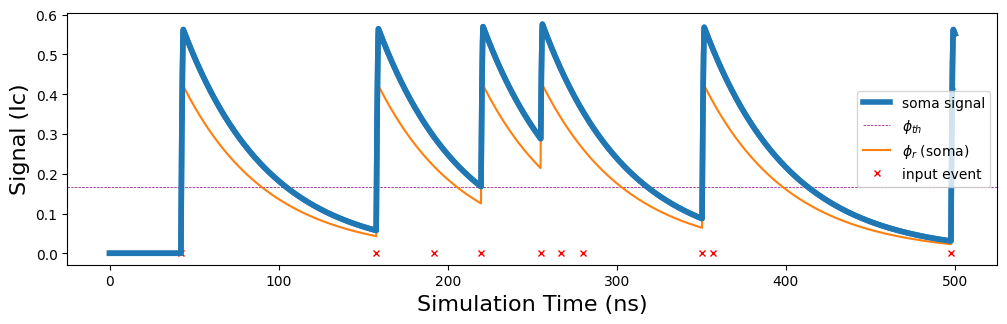


        Plots signal activity for a given neuron
            - net        -> network within which neurons were simulated
            - phir       -> plot phi_r of soma and phi_r thresholds
            - dend       -> plot dendritic signals
            - input      -> mark moments of input events with red spikes
            - SPD        -> plot synaptic flux
            - ref        -> plot refractory signal
            - weighting  -> weight dendritic signals by their connection strength
            - spikes     -> plot output spikes over signal
            - legend_out -> place legend outside of plots
            - size       -> (x,y) size of figure
            - path       -> save plot to path
            
        


In [4]:
# random spike train for one input channel with ten spikes total over 100ns
input = SuperInput(channels=1, type='random', total_spikes=10, duration=500)

# note, any neuron or dendrite parameters can be passed into the node class init
node = SuperNode(s_th=100) # large spiking threshold to avoid spiking for now

# adding input uniformly to available synapse on node's neuron
# in this case there is only one synapse attached to the somatic dendrite
node.uniform_input(input)

# create and simulate a (single node) network
net = network(
    sim=True,     # run simulation
    dt=.1,        # time step (ns)
    tf=500,       # total duration (ns)
    nodes=[node]) # nodes in network to simulate

# plot neuron activity
node.plot_neuron_activity(net,spikes=True,phir=True,input=input)
print(node.plot_neuron_activity.__doc__)

***Exercise!***
 - 1.2 Play with the below node parameters 
   - Note, these are ultimately somatic dendrite params (denoted by _ni suffix)
 - 1.3 Attempt to get zero,five, and ten output spikes for your random input spike train!
 - 1.4 Try to define the influence of each parameter
 - 1.5 Understand the role of the red line (refractory dendrite signal)

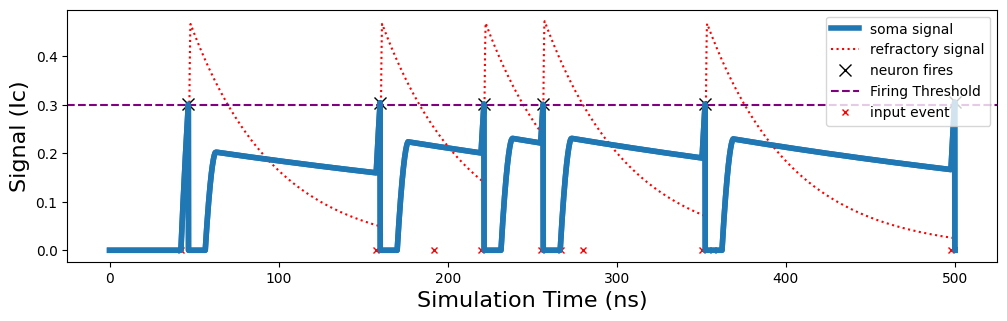

In [5]:
node = SuperNode(
    s_th    = .3,           # spiking threshold    (you choose)
    ib_n    = 2,            # bias current         (must be between 1.4 and 2.05)
    tau_ni  = 400,          # time constant        (and positive value)
    beta_ni = 2*np.pi*1e3,  # inductance parameter (just change the exponent)
    ) 

node.uniform_input(input)

net = network(sim=True,dt=.1,tf=500,nodes=[node])

node.plot_neuron_activity(net,ref=True,spikes=True,input=input)

### Parameters
While there are many fabrication determined physical constants associated with a SOEN neuron, there are only three main dendritic parameters for moderating computation:
 - $i_b$ = `ib`   = bias current (determines how much signal can be integrated into a dendrite)
 - $\tau$ = `tau`  = the time constant by which integrated signal can be leaked
 - $\beta$ = `beta` = determines inductor size in the integration loop (and therefore moderates both integration and decay)

These parameters influence signal integration for any given dendrite according to:

\begin{equation}
s_{t+1} = s_t(1-\Delta t\frac{\alpha}{\beta}+\frac{\Delta t}{\beta} r(\phi,s,i_b))
\end{equation}

where $\tau = \alpha/\beta$.  Note that all dendrites have these parameters.  We use the `_ni` suffix for the somatic dendrite specifically and the `_di` for all arbor dendrites.

The final term in equation (1) includes the rate array function $r(\phi,s,i_b)$ which refers to a pre-derived three-dimensional surface defined by: 
 - $s$ = accumulated signal in the dendritic integreation loop at the previous time step
 - $\phi_r$ =  received flux via couplings into the dendritic recieving loop
 - $r_{fq}$ = flux quantum production (fluxons emmitted from receiving loop to integration loop)

`s` and `phi_r` are used to reference `r_fq`, which determines new signal to be accumulated (via fluxons) into the dendritic integration loop.  Refering to the below plot, we see that for greater values of $s$, there is less flux quantum production for the same received flux $\phi_r$.  This is because the loop approaches *saturation*.  


We also see that for different values of $i_b$, greater $r_{fq}$ values can be achieved for equivalent $s$ and $\phi_r$ values because the saturation limit is rasied.
![ title](img/rate_arrays.png)

### Saturation
***Exercise!***
 - (1.5) Run the code below and observe that signal integration approaches a limit in all three signal frequency domains.  In some cases the input/decay rate.  In other cases, however, the signal is simply saturation.  What parameter can be changed to know the difference?
   - **hint -> We want to be sure that the signal is not simply leaking at about the same frequency that is being integrated*

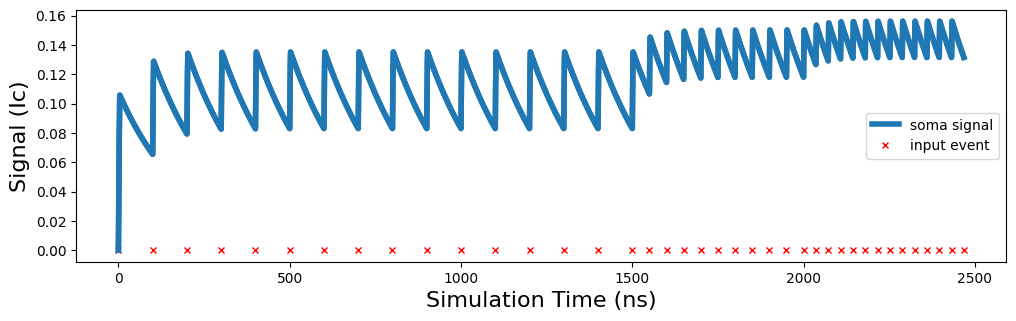

In [6]:
spike_times_1 = np.arange(0,1500,100)   # lowest frequency
spike_times_2 = np.arange(1500,2000,50) # higher frequency
spike_times_3 = np.arange(2000,2500,36) # very high frequency

# combine them into one list of spike times
times = np.concatenate([spike_times_1,spike_times_2,spike_times_3]) 

# all spikes occur at the same (first = zeroth) input channel
indices = np.zeros(len(times)).astype(int)

# this canonical array form of all spike data
def_spikes = [indices,times]

# create SuperInput object according to defined spikes
input = SuperInput(channels=1, type='defined', defined_spikes=def_spikes, duration=np.max(times))

# typical node construction
node = SuperNode(
    s_th    = 100,          # spiking threshold    (you choose)
    ib_n    = 1.4,          # bias current         (must be between 1.4 and 2.05)
    tau_ni  = 200,          # time constant        (and positive value)
    beta_ni = 2*np.pi*1e3,  # inductance parameter (just change the exponent)
    ) 

# all (there's only one) synapses get the same input
node.uniform_input(input)

# create and simulate (single neuron) network
net = network(sim=True,dt=.1,tf=np.max(times),nodes=[node])

# plot activity
node.plot_neuron_activity(net,spikes=True,input=input)

### Rollover

***Exercise!***
 - `w_sd` = coupling strength between synapse and dendrite (in this case the somatic dendrite)
 - 1.6 Analyize the following plot and then run the code.  Given our new parameter, signal integration may not behave as expected.  Can you explain why? (y-axis = r_fq and x-axis = phi_r, *make better plot)
 - 1.7 Play around with different values of ib_n and w_sd.  Pay attention to hte $\phi_{th}$ line.  What does it demarcate?

![ title](img/phi_period.png)

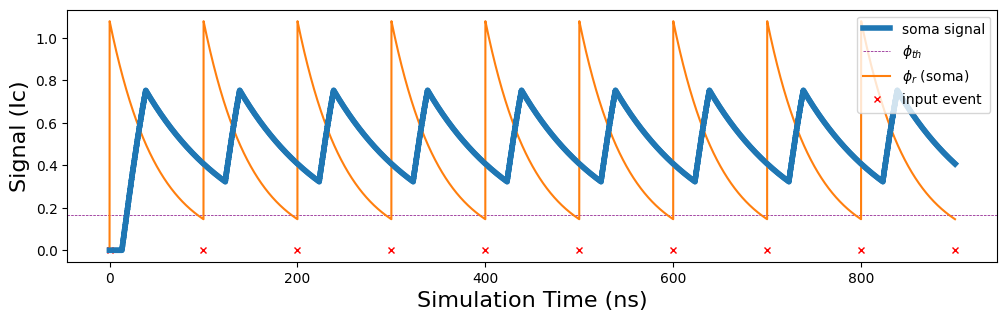

In [7]:
times = np.arange(0,1000,100)
indices = np.zeros(len(times)).astype(int)
def_spikes = [indices,times]
input = SuperInput(channels=1, type='defined', defined_spikes=def_spikes, duration=np.max(times))

node = SuperNode(
    s_th    = 100,          # spiking threshold    (you choose)
    ib_n    = 1.8,          # bias current         (must be between 1.4 and 2.05)
    tau_ni  = 100,          # time constant        (and positive value)
    beta_ni = 2*np.pi*1e2,  # inductance parameter (just change the exponent)
    w_sd=2.5,               # determines coupling strength of synapse to dendrite
    ) 

node.uniform_input(input)

net = network(sim=True,dt=.1,tf=np.max(times),nodes=[node])

node.plot_neuron_activity(net,spikes=True,input=input,phir=True,ref=False)

## Part 2: Dendritic Arbors
 - Biological neurons are much more than soma and a synapse!
 - SOEN neurons therefore incorporate potentially large dendrite structures
 - This allows for complex computations to occur at the single neuron level!

### Building Structure
 - Using `SuperNode`, arbitrary dendritic trees (or arbors) can be built
 - Simply pass in a `weights` argument and a dendritic tree will be built with this shape
 - Each value in `weights` determines the coupling strength of that connection

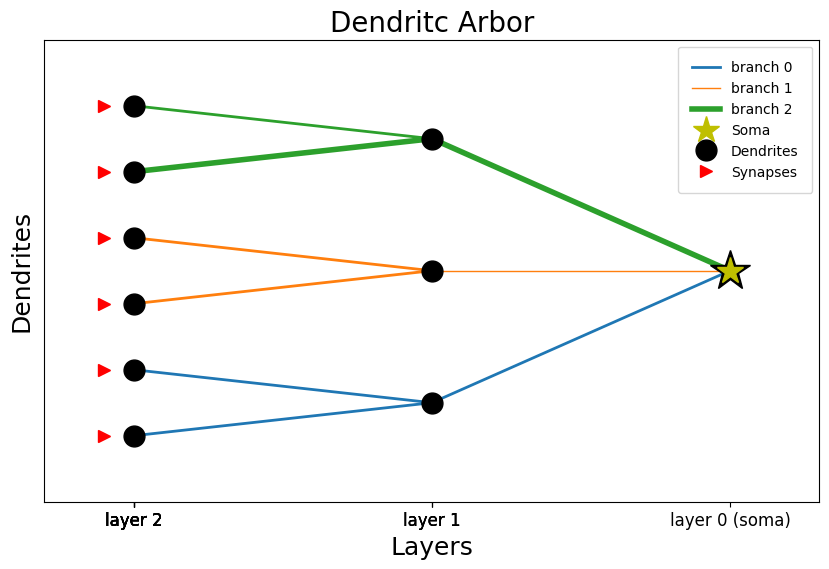

In [8]:
weights = [
    [[0.4,.3,.8]],
    [[.5,.5],[.5,.5],[.9,.5]]
    ]
node = SuperNode(weights=weights)
node.plot_structure()

### Synaptic Structure
 - Mostly, we would like to simply use the default synaptic layer at the outermost dendrite of the tree
 - However, if custom synaptic structure are desired, a list of arbor structure (now including one extra preceding layer for the soma) can be included to define synapse locations.  One structure per synapse.

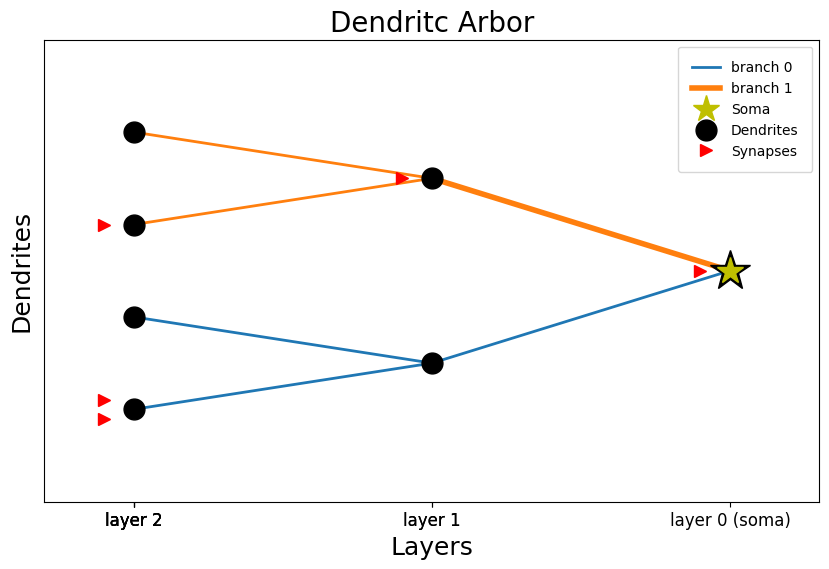

In [9]:
weights = [
    [[0.4,.8]],
    [[.5,.5],[.5,.5]]
    ]

syn_struct = [

    [[[0]],
    [[0,0]],
    [[1,0],[0,0]]],

    [[[0]],
    [[0,0]],
    [[1,0],[0,0]]],

    [[[0]],
    [[0,0]],
    [[0,0],[1,0]]],

    [[[0]],
    [[0,1]],
    [[0,0],[0,0]]],

    [[[1]],
    [[0,0]],
    [[0,0],[0,0]]],

]

node = SuperNode(weights=weights,synaptic_structure=syn_struct)
node.plot_structure()

### Part 3: Computing with A Single Neuron
***Exercise!***
 - (3.1) Try inventing an AND gate such that the neuron only fires when receiving input at both synapses simultaneously
 - (3.2) Now try inventing the OR gate!

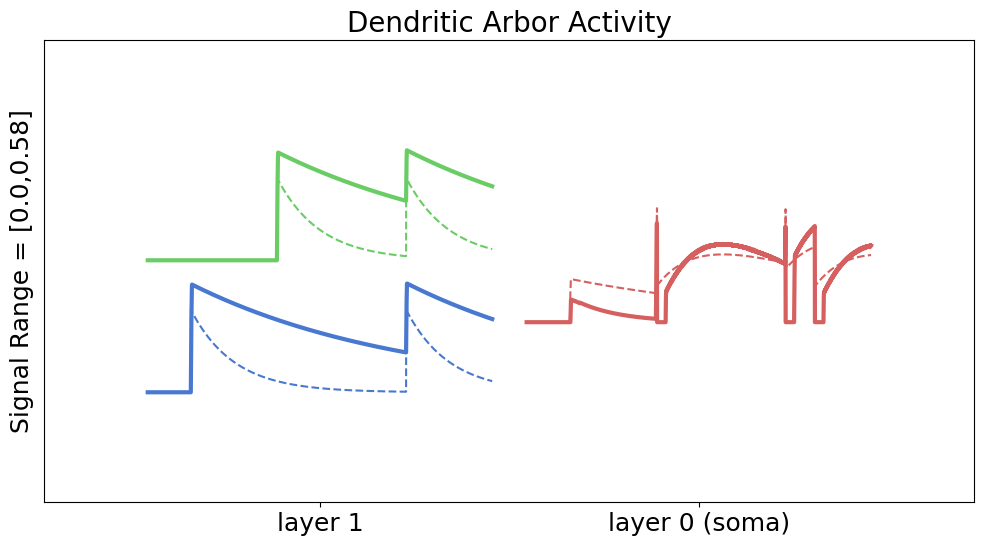

In [10]:
times = [50,150,300,300]
indices = [0,1,0,1]
def_spikes = [indices,times]
input = SuperInput(channels=2, type='defined', defined_spikes=def_spikes, duration=400)
# from soen_plotting import raster_plot
# raster_plot(input.spike_arrays)

weights = [
    [[0.4,.8]],
    ]


connect = [[0,0],[1,1]]


# synaptic layer automatically draped over outer-most dendrites
node = SuperNode(weights=weights)

node.multi_channel_input(input,connect)

net = network(sim=True,dt=.1,tf=400,nodes=[node])

node.plot_arbor_activity(net,phir=True)


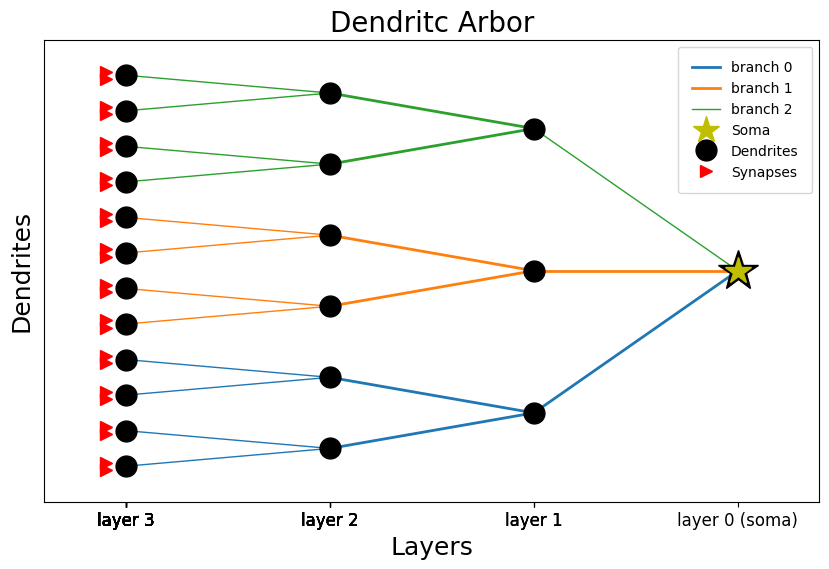

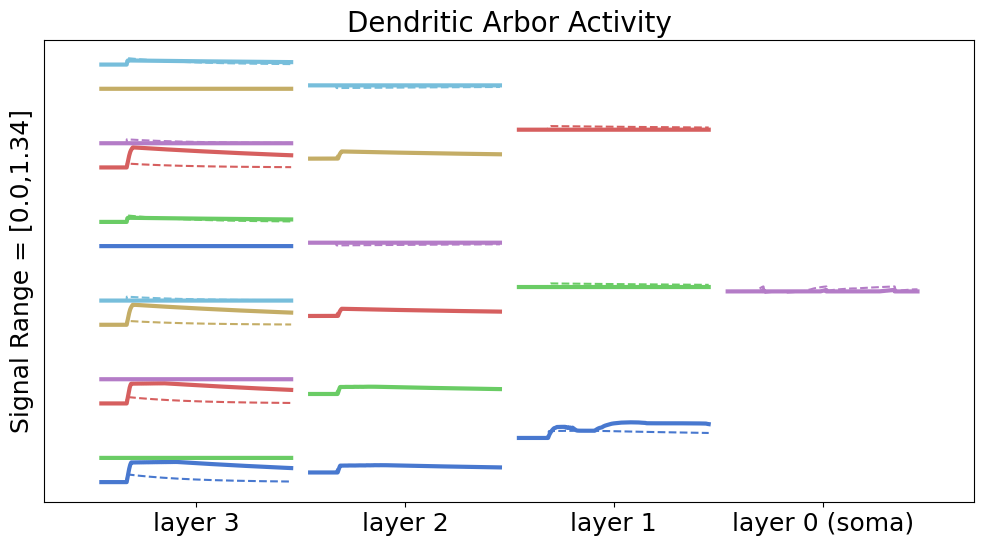

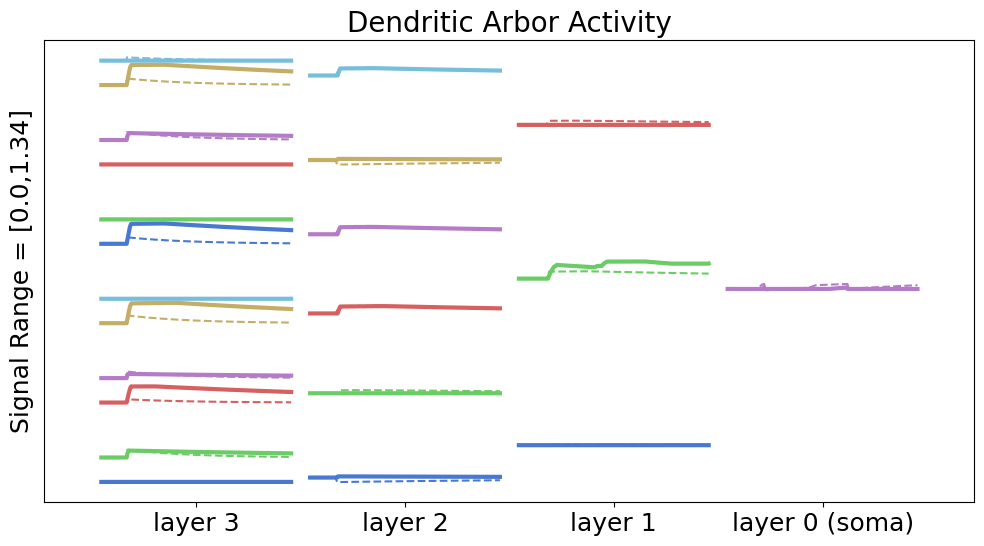

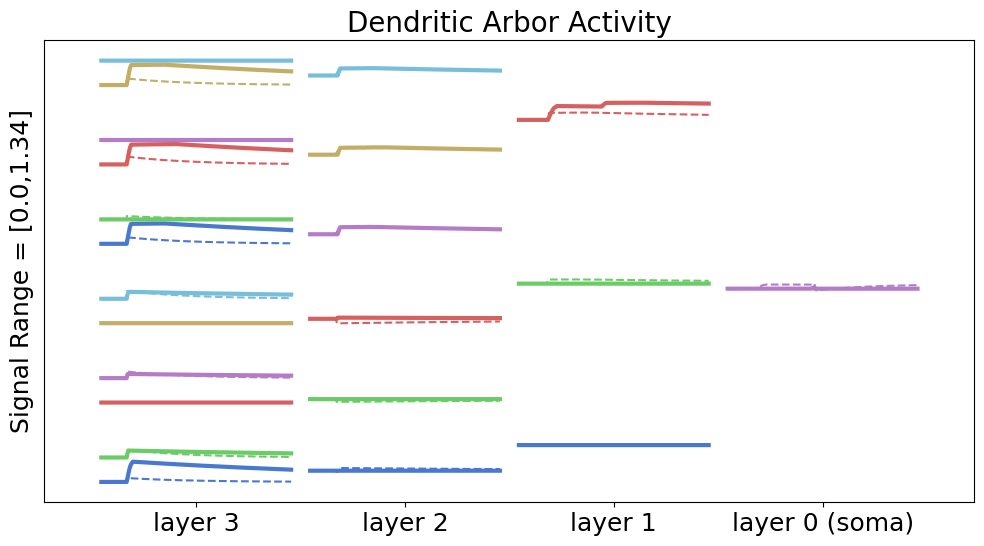

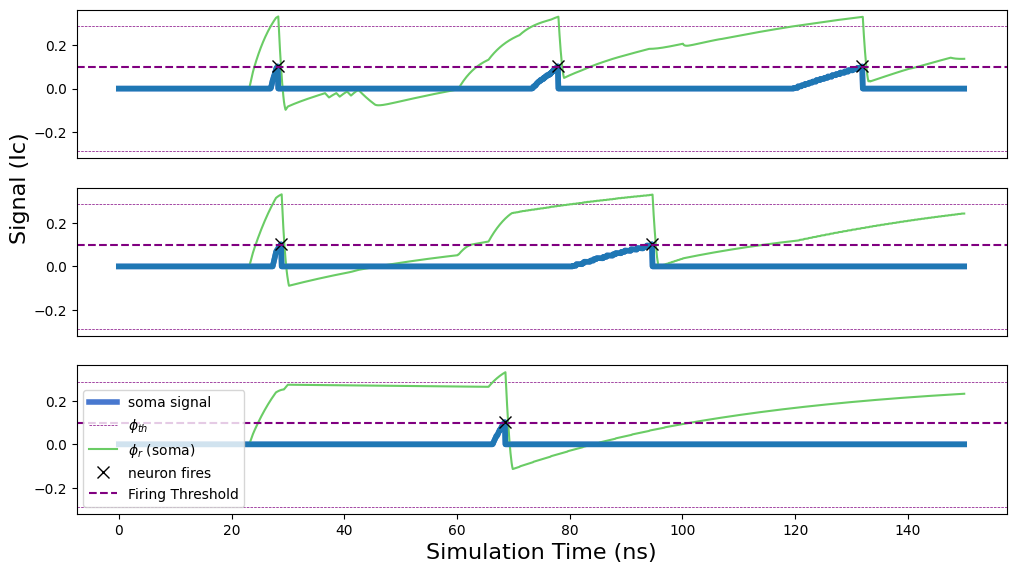

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# from super_library import NeuralZoo
from super_input import SuperInput
from soen_sim import network
from soen_plotting import activity_plot, arbor_activity, structure

from super_node import SuperNode
from soen_plotting import raster_plot

ib__list__ri = [1.3523958588352205, 1.4023958588352206, 1.4523958588352206, 
                1.5023958588352206, 1.5523958588352207, 1.6023958588352207, 
                1.6523958588352208, 1.7023958588352208, 1.7523958588352209, 
                1.802395858835221, 1.852395858835221, 1.902395858835221, 
                1.952395858835221, 2.002395858835221, 2.0523958588352214]

ib__list__rtti = [1.5, 1.57666667, 1.65333333, 1.73, 1.80666667, 1.88333333,
                1.96, 2.03666667, 2.11333333, 2.19, 2.26666667, 2.34333333,
                2.42,.49666667, 2.57333333, 2.65]

params = {
    'weights': [
        [[.5,.4,.3]],
        [[0.5,0.5],[0.5,0.5],[0.5,0.5]],
        [[0.35,-0.65],[0.35,-0.65],[0.35,-0.65],[0.35,-0.65],[0.35,-0.65],[0.35,-0.65]]
    ],
    'taus': [
        [[10,150,1000]],
        [[250,250],[250,250],[250,250]],
        [[250,250],[250,250],[250,250],[250,250],[250,250],[250,250]]
    ],

    'biases': [
        [[3,3,3]],
        [[5,5],[5,5],[5,5]],
        [[-4,3],[-4,3],[-4,3],[-4,3],[-4,3],[-4,3]]
    ],
    'types': [
        [['rtti','rtti','rtti']],
        [['ri','ri'],['ri','ri'],['ri','ri']],
        [['rtti','ri'],['rtti','ri'],['rtti','ri'],['rtti','ri'],['rtti','ri'],['rtti','ri']]
    ],
    'syns': [['2','5'],['4','6'],['5','8'],['4','6'],['1','3'],['7','9'],
             ['4','6'],['2','5'],['7','9'],['1','3'],['4','6'],['5','8']],
    'syn_w': [[.6,.6],[.5,.5],[.6,.6],[.5,.5],[.6,.6],[.5,.5],
              [.6,.6],[.5,.5],[.6,.6],[.5,.5],[.6,.6],[.5,.5]],
       
    # "ib_ne": ib__list__ri[4],
    "tau_di": 250,
    "ib_n": ib__list__ri[4], 
    "beta_ni": 2*np.pi*1e2,
    "tau_ni": 50,
    "w_sd": 1,
    "ib_ref": ib__list__ri[8], 
    "beta_ref": 2*np.pi*1e2,
    "tau_ref": 50,
    'ib_list_ri':ib__list__ri[:],
    'ib_list_rtti':ib__list__rtti[:],
}

nine_neuron = SuperNode(s_th=.1,**params) 
nine_neuron.plot_structure()

z = np.array([0,1,4,7,8]) # z-pixel array
v = np.array([1,4,3,6,8])-1 # v
n = np.array([2,4,6,7,9])-1 # n
letters = [z,v,n]

z = np.array([0,1,4,7,8]) # z-pixel array
v = np.array([1,4,3,6,8])-1 # v
n = np.array([2,4,6,7,9])-1 # n
letters = [z,v,n]

run_neurons = []

for let in letters:
    nine_neuron = SuperNode(s_th=.1,**params) 
    indices = let
    times = np.ones(len(indices))*20
    def_spikes = [indices,times]
    input = SuperInput(channels=9, type='defined', defined_spikes=def_spikes, duration=100)
    # raster_plot(input.spike_arrays)
    count = 0
    for g in nine_neuron.synapses:
        for s in g:
            for i,row in enumerate(input.spike_rows):
                if i == int(s.name)-1:
                    s.add_input(input.signals[i])
                    count+=1
    run_neurons.append(nine_neuron)

net = network(sim=True,dt=.1,tf=150,nodes=run_neurons,new_way=True)

for n in run_neurons:
    n.plot_arbor_activity(net,phir=True)

activity_plot(run_neurons,net,dend=False,phir=True,size=(12,8))

    

### Part 5: Networking and Dynamics
 - Network demo with computation example!

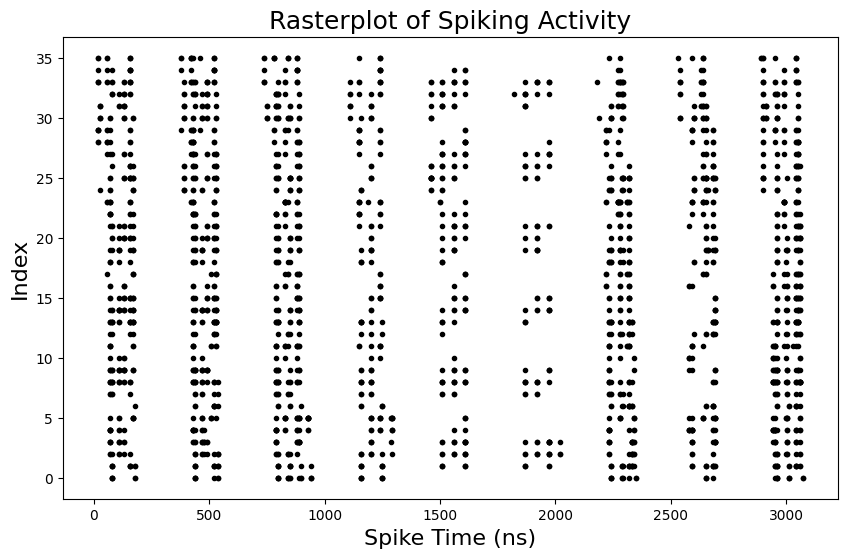

In [12]:
from super_net import PointReservoir
from soen_plotting import raster_plot
from super_functions import picklin
input = picklin("results","saccade_mnist_10")
raster_plot(input.spike_arrays)

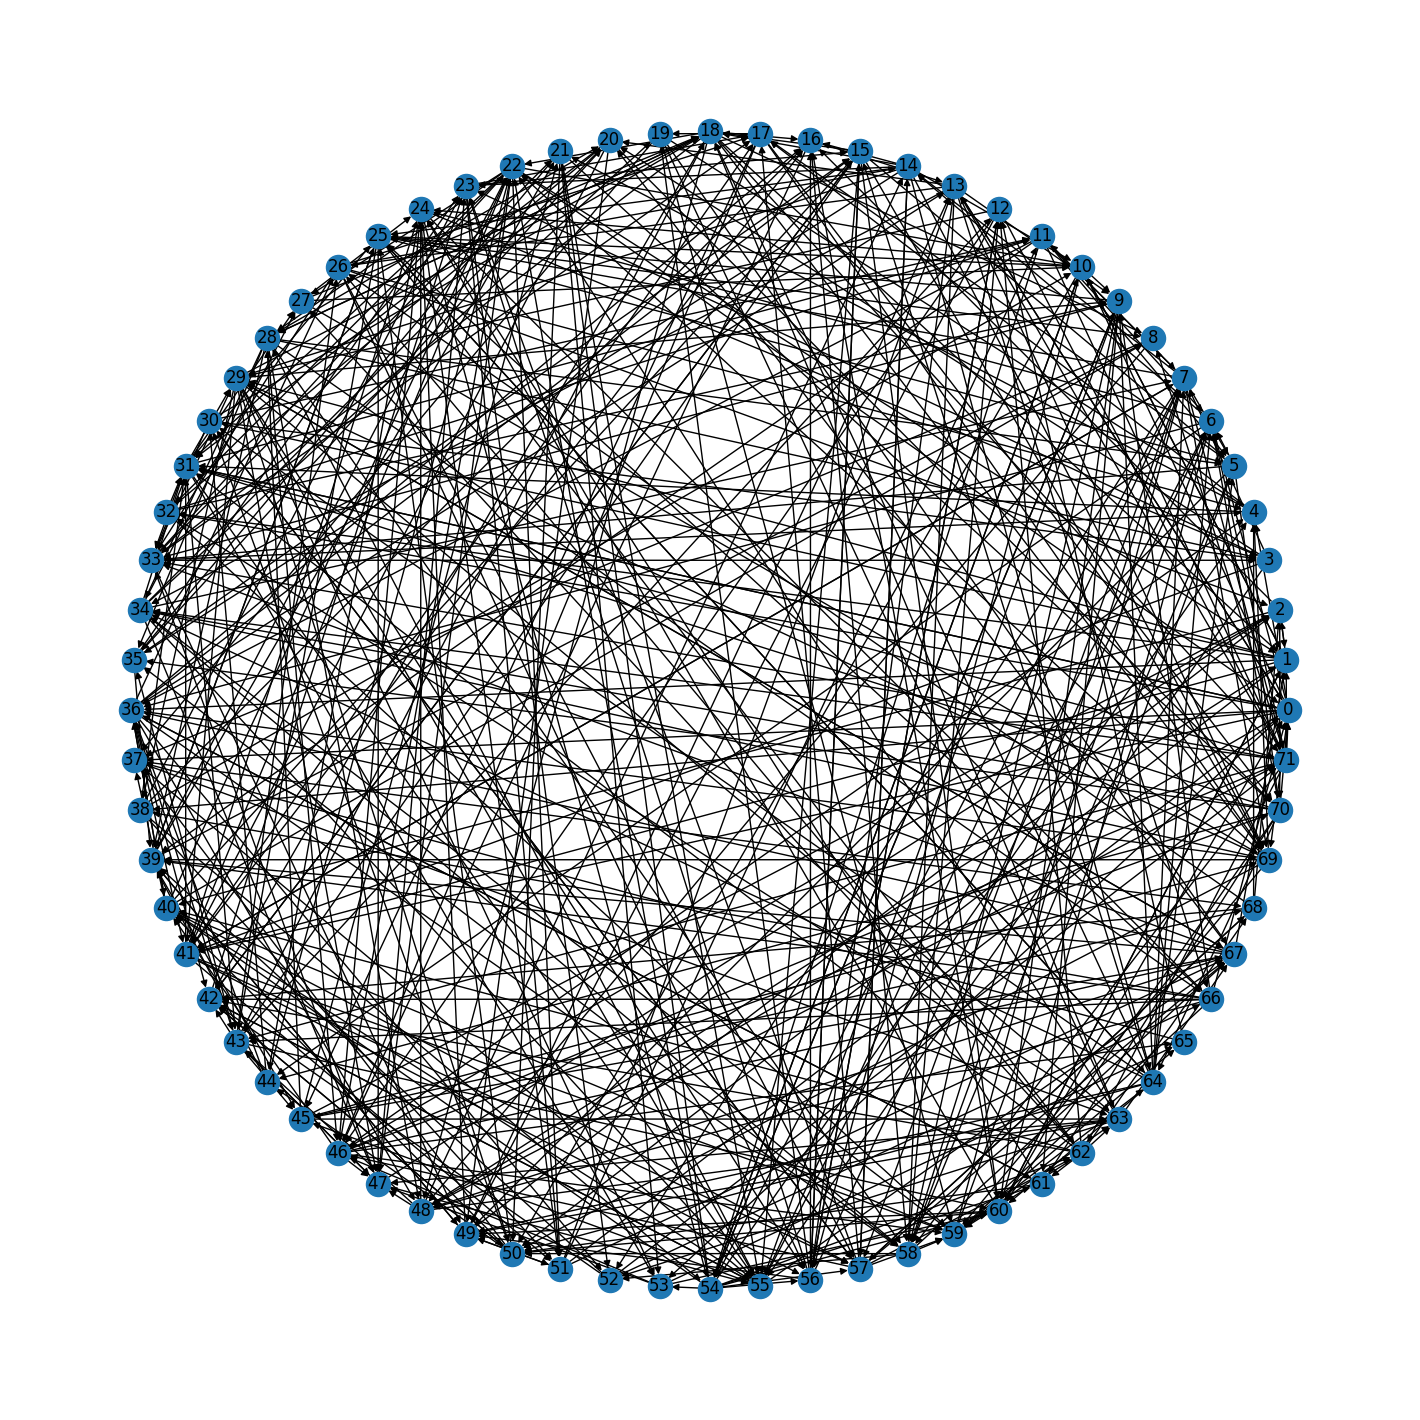

In [13]:
# Reservoir params
params= {
    "N":72,
    "s_th":0.5,
    "beta":2*np.pi*10**2,
    "tau":100,
    "tau_ref":50,
    "tf":3600,
    "run":1,
    }

res = PointReservoir(**params)
res.graph_net()

In [14]:

res.connect_input(input)
# res.graph_input()

running network


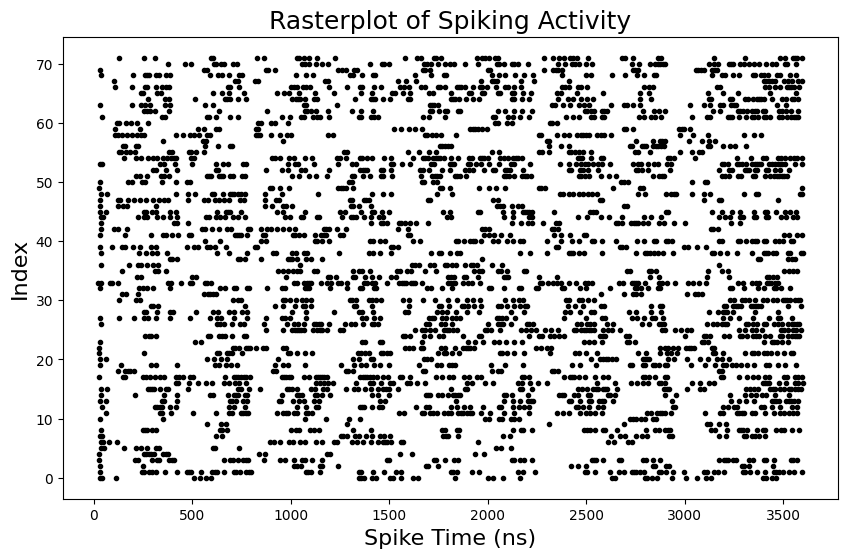

In [15]:
res.run_network()
raster_plot(res.net.spikes)